In [1]:
import numpy as np
import pandas as pd
import pickle
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.io import fits
from typing import Tuple
from astropy.coordinates import SkyCoord, Angle, concatenate

In [31]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_photometry.pkl', 'rb') as f:
    final_photometry = pickle.load(f)
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_cat.pkl', 'rb') as f:
    final_cat = pickle.load(f)

# SN-Host Association

In [32]:
fits_data = np.array(fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/es1.v1.fits')[1].data)
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/wcdfs.v1.fits')[1].data))
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/xmmlss.v1.fits')[1].data))

In [33]:
def get_coords_for_ids(gal_ids: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)

    # Sort the coordinates
    sorted_inds = np.argsort(coord_lookup_table['gal_id'])
    lup_tab_sorted = coord_lookup_table[sorted_inds]
    print('Sorted')
    
    # Find the sorted indices of 'a' in 'b'
    indices_in_b_sorted = np.searchsorted(lup_tab_sorted['gal_id'], gal_ids, side='left')
    print('Search complete')
    
    # Make sure that all elements of 'a' are actually present in 'b'
    indices_in_b_sorted = indices_in_b_sorted[indices_in_b_sorted < len(coord_lookup_table['gal_id'])]
    valid_mask = lup_tab_sorted['gal_id'][indices_in_b_sorted] == gal_ids
    indices_in_b_sorted = indices_in_b_sorted[valid_mask]
    print('Validation complete')

    # Take the sorted indices and map back to original indices in 'b'
    all_indices = lup_tab_sorted[indices_in_b_sorted]
    
    return all_indices

In [34]:
# Sort our data so that we can put the gal_id identifier on
value_to_index = {value: idx for idx, value in enumerate(np.log10(fits_data['Mstar_best']))}
data_indices = np.array([value_to_index.get(value, None) for value in final_cat['data'][:, 0]])
data_indices

array([  88249,   88250,   88251, ..., 2625845, 2625846, 2625847])

In [35]:
coord_lookup_table = fits_data['Tractor_ID'][data_indices]
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['RA'][data_indices]))
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['DEC'][data_indices]))
coord_lookup_table = np.vstack((final_photometry['gal_id'], coord_lookup_table))
coord_lookup_table = coord_lookup_table.T

# Convert columns to appropriate types and form the structured array
dtypes = [('gal_id', 'u4'), ('tractor_id', 'S32'), ('RA', 'f8'), ('DEC', 'f8')]
coord_lookup_table = np.array(list(zip(coord_lookup_table[:, 0].astype(int), coord_lookup_table[:, 1], coord_lookup_table[:, 2].astype(float), coord_lookup_table[:, 3].astype(float))), dtype=dtypes)

with open('/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl', 'wb') as f:
    pickle.dump(coord_lookup_table, f)

In [36]:
sne = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/sn_coords.csv')
desired_cols = ['event', 'alias', 'catalog', 'claimedtype', 'dec', 'discoverdate',
       'discoverer', 'download', 'ebv', 'host', 'hostdec', 'hostoffsetang',
       'hostoffsetdist', 'hostra', 'instruments', 'lumdist', 'maxabsmag',
       'maxappmag', 'maxdate', 'name', 'photolink', 'ra', 'radiolink',
       'redshift', 'references', 'spectralink', 'velocity', 'xraylink']
sne = sne[desired_cols]
sne.head()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_931/688078253.py:1: DtypeWarning: Columns (7,8,11,12,15,16,17,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,74,78,79,80,81,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  sne = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/sn_coords.csv')


,event,alias,catalog,claimedtype,dec,discoverdate,discoverer,download,ebv,host,...,maxdate,name,photolink,ra,radiolink,redshift,references,spectralink,velocity,xraylink
0,10Z2-A,10Z2-A,sne,NaN,+00:00:39.7,NaN,NaN,NaN,0.0337,NaN,...,NaN,10Z2-A,NaN,10:47:06.52,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
1,10Z2-B,10Z2-B,sne,NaN,+00:00:28.0,NaN,NaN,NaN,0.0383,NaN,...,NaN,10Z2-B,NaN,10:45:42.76,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
2,10Z2-D,10Z2-D,sne,NaN,-00:13:52.7,NaN,NaN,NaN,0.0318,NaN,...,NaN,10Z2-D,NaN,10:47:40.94,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
3,1156-62,"1156-62,G296.8-00.3,MWSNR 296.8-00.3",sne,NaN,-62:35,NaN,NaN,NaN,NaN,Milky Way,...,NaN,1156-62,NaN,11:58:30,NaN,NaN,2014BASI...42...47G,NaN,NaN,NaN
4,13Z3-A,13Z3-A,sne,NaN,-00:14:22.1,NaN,NaN,NaN,0.0241,NaN,...,NaN,13Z3-A,NaN,13:43:28.86,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN


In [37]:
# Drop one super annyoing supernova data point
sne = sne[sne['event'] != 'SN1572A']

# Do some data filtering because the API returned some weird stuff
mask = sne['claimedtype'] == 'sne'      # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias'] = np.nan         # Set 'alias' values to NaN for those rows
sne.loc[mask, 'alias':] = sne.loc[mask, 'alias':].shift(axis=1, periods=-1) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['dec'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'catalog'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'catalog':] = sne.loc[mask, 'catalog':].shift(axis=1, periods=-2) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['discoverdate'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'claimedtype'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'claimedtype':] = sne.loc[mask, 'claimedtype':].shift(axis=1, periods=-3) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['discoverer'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'dec'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'dec':] = sne.loc[mask, 'dec':].shift(axis=1, periods=-4) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['download'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'discoverdate'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'discoverdate':] = sne.loc[mask, 'discoverdate':].shift(axis=1, periods=-5) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['host'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'discoverer'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'discoverer':] = sne.loc[mask, 'discoverer':].shift(axis=1, periods=-6) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['hostdec'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'download'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'download':] = sne.loc[mask, 'download':].shift(axis=1, periods=-7) # Shift everything to the right of 'alias' one column to the left

# Find the host coordinates of all the sne without host coordinates already
host_mask = ~sne[['hostra', 'hostdec']].isna().any(axis=1)  # mask for hosts with valid coords
sne_mask = ~sne[['ra', 'dec']].isna().any(axis=1)           # mask for sne with valid coords
sne_mask[host_mask] = True                                  # we don't care abt not having sne coords if we have host coords
good_row_mask = ~host_mask & sne_mask                       # only search for the sne host if we don't know the host and we have the sne coords
sne = sne[good_row_mask]                                    # Only take the good rows
sne = sne.reset_index()

In [38]:
n_classified = len(sne[(sne['claimedtype'] != 'Candidate')]['claimedtype'].dropna())
print(f"The number of classified galaxies in the OSC catalog is {len(sne[(sne['claimedtype'] != 'Candidate')]['claimedtype'].dropna())}")

The number of classified galaxies in the OSC catalog is 17319


In [39]:
print(f'Total # of SNe in the catalog = {len(sne)}\n# of classified SNe in the catalog = {n_classified}')
print('% of classified SNe that are type Ia = ', sne['claimedtype'].str.contains('ia', case=False, na=False).sum() / n_classified)

Total # of SNe in the catalog = 82605
# of classified SNe in the catalog = 17319
% of classified SNe that are type Ia =  0.5813268664472545


In [40]:
# Find the host coordinates of all the sne without host coordinates already
sne_names = sne['name'].to_numpy()                  # array of sne names
host_coords = sne[['hostra', 'hostdec']]            # host coordst array
sne_coords = sne[['ra', 'dec']]                     # sne coords array

# Convert everything to np arrays
sne_coords = sne_coords.to_numpy()
host_coords = host_coords.to_numpy()

# Get list of sky coordinates objects for sne with no host and complete sne coords
sne_ra = []
sne_dec = []
for ra, dec in sne_coords:
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')

    sne_ra.append(ra_ang.wrap_at("24h").deg)
    sne_dec.append(dec_ang.deg)

# sne_ra = np.array([Angle(ra.split(',')[0], unit='hourangle') for ra in sne_coords[to_find_mask][:, 0]])                 # NOTE: The .split(',') is because there are actually multiple ra measuremenets
# sne_dec = np.array([Angle(dec.split(',')[0], unit='hourangle') for dec in sne_coords[to_find_mask][:, 1]])              # NOTE: The .split(',') is because there are actually multiple dec measuremenets
# sn_sky_coords = np.array([SkyCoord(ra * u.deg, dec * u.deg, frame='icrs') for ra, dec in zip(sne_ra, sne_dec)])
sn_sky_coords = SkyCoord(sne_ra * u.deg, sne_dec * u.deg, frame='icrs')
sne['sky_coord'] = sn_sky_coords

## Panstarrs

In [41]:
panstarrs = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/panstarrs_photometry.csv')
panstarrs.head()

,Unnamed: 0,raMean,decMean,gMeanApMag,rMeanApMag,iMeanApMag,zMeanApMag,yMeanApMag,gMeanApMagErr,rMeanApMagErr,iMeanApMagErr,zMeanApMagErr,yMeanApMagErr
0,132154,215.981264,-30.893196,20.659700,19.312300,19.120501,18.530300,19.748699,0.000017,0.049426,0.002382,0.000023,1.405110
1,133108,215.980224,-30.861693,18.380199,17.988600,17.547899,17.769699,17.690800,0.018132,0.016826,0.072540,0.007477,0.094229
2,133562,215.997200,-30.873493,19.069500,18.497000,18.198700,18.309099,18.300301,0.052039,0.047208,0.000711,0.030293,0.146506
3,133600,215.993190,-30.864260,18.058800,17.502100,17.193800,17.255600,17.067699,0.010571,0.013286,0.044424,0.020100,0.017577
4,133689,215.945175,-30.860252,20.843300,19.716801,19.067600,18.237400,18.308701,0.016565,0.125088,0.040192,0.121005,0.034092


In [42]:
max_field_raidus = 4  # 1.3 is the approximate radius of the depe field
classified_mask = sne['claimedtype'] != 'Candidate'
nan_mask = sne[classified_mask]['claimedtype'].to_numpy().astype(str) == 'nan'
print(f'There are {np.sum(~nan_mask)} supernovae.')
print(f"Of those, approximate {len(sne[classified_mask]['claimedtype'].dropna())} are classified.")
print(f"Of the classified, {sne['claimedtype'][classified_mask].str.contains('ia', case=False, na=False).sum() / len(sne[classified_mask]['claimedtype'].dropna())} are type Ia")
classified_sne = sne[classified_mask][~nan_mask]

There are 17319 supernovae.
Of those, approximate 17319 are classified.
Of the classified, 0.5813268664472545 are type Ia


In [44]:
panstarrs_coords = SkyCoord(panstarrs['raMean'].to_numpy() * u.deg, panstarrs['decMean'].to_numpy() * u.deg, frame='icrs')
smallest_seps = np.array([None for _ in range(len(classified_sne))])
pstar_hosts_30 = np.array([None for _ in range(len(classified_sne))])
pstar_hosts_60 = np.array([None for _ in range(len(classified_sne))])
n = len(concatenate(classified_sne['sky_coord']))

# For each supernova, find the host galaxy
for i, coord in enumerate(concatenate(classified_sne['sky_coord'])):
    if i%1000 == 0:
        print(f'{i} / {n}')
    gal_seps = coord.separation(panstarrs_coords).arcsec
    smallest_sep = np.min(gal_seps)
    smallest_sep_ind = np.argmin(gal_seps)
    if smallest_sep < 30:  # Host if the host is less than a 30 arcsec separation
        pstar_hosts_30[i] = final_cat['gal_id'][smallest_sep_ind]
        smallest_seps[i] = smallest_sep
    if smallest_sep < 60:  # Host if the host is less than a 30 arcsec separation
        pstar_hosts_60[i] = final_cat['gal_id'][smallest_sep_ind]

0 / 17319
1000 / 17319
2000 / 17319
3000 / 17319
4000 / 17319
5000 / 17319
6000 / 17319
7000 / 17319
8000 / 17319
9000 / 17319
10000 / 17319
11000 / 17319
12000 / 17319
13000 / 17319
14000 / 17319
15000 / 17319
16000 / 17319
17000 / 17319


In [45]:
np.sum(pstar_hosts_30 is not None)

1

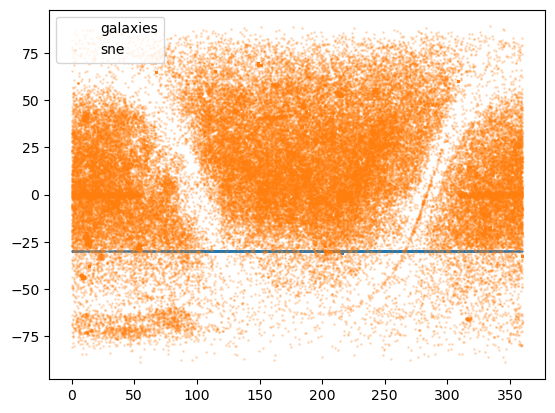

In [46]:
plt.scatter(panstarrs['raMean'], panstarrs['decMean'], s=0.1, alpha=0.1, label='galaxies')
plt.scatter(np.array(sne_ra), np.array(sne_dec), s=1, label='sne', alpha=0.2)
plt.legend(loc=2)
# plt.xlim((32, 40))
# plt.ylim((-7, -3))
plt.show()

## DDFs

In [16]:
# The centers of the three deep fields
wcdfs_center = SkyCoord(Angle('03:32:09', unit='hourangle').deg * u.deg, Angle('-28:08:32 degrees').deg * u.deg, frame='icrs')
es1_center = SkyCoord(Angle('00:37:47', unit='hourangle').deg * u.deg, Angle('-44:00:07 degrees').deg * u.deg, frame='icrs')
xmmlss_center = SkyCoord(Angle('02:22:10', unit='hourangle').deg * u.deg, Angle('-04:45:00 degrees').deg * u.deg, frame='icrs')

# Get the seperation of each SN from the center of the field
field_seps = np.zeros((len(sn_sky_coords), 3))
for i, field_center in enumerate((wcdfs_center, es1_center, xmmlss_center)):
    field_seps[:, i] = field_center.separation(sn_sky_coords).degree
min_sep = np.min(field_seps, axis=1)
print(min_sep)
print(np.min(min_sep))

[106.4619733  106.15641833 106.46747375 ...   7.32107933  43.03772154
 126.48246176]
0.07885258304887599


In [17]:
max_field_raidus = 4  # 1.3 is the approximate radius of the depe field
in_field_mask = min_sep < max_field_raidus
classified_mask = sne[in_field_mask]['claimedtype'] != 'Candidate'
nan_mask = sne[in_field_mask][classified_mask]['claimedtype'].to_numpy().astype(str) == 'nan'
print(f'There are {np.sum(in_field_mask)} supernovae within the deep fields.')
print(f"Of those, approximate {len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are classified.")
print(f"Of the classified, {sne['claimedtype'][in_field_mask][classified_mask].str.contains('ia', case=False, na=False).sum() / len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are type Ia")
classified_field_sne = sne[in_field_mask][classified_mask][~nan_mask]

There are 965 supernovae within the deep fields.
Of those, approximate 586 are classified.
Of the classified, 0.7491467576791809 are type Ia


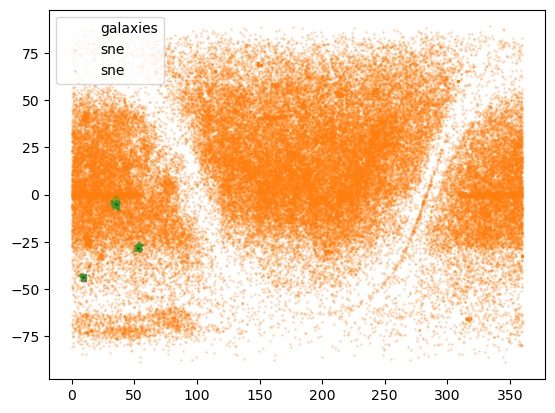

In [18]:
centers = np.array([[Angle('03:32:09', unit='hourangle').deg, Angle('-28:08:32 degrees').deg], [Angle('00:37:47', unit='hourangle').deg, Angle('-44:00:07 degrees').deg], [Angle('02:22:10', unit='hourangle').deg, Angle('-04:45:00 degrees').deg]])
plt.figure()
plt.scatter(fits_data['RA'], fits_data['DEC'], s=0.1, alpha=0.1, label='galaxies')
plt.scatter(np.array(sne_ra), np.array(sne_dec), s=1, label='sne', alpha=0.2)
plt.scatter(np.array(sne_ra)[in_field_mask][classified_mask][~nan_mask], np.array(sne_dec)[in_field_mask][classified_mask][~nan_mask], s=1, label='sne', alpha=0.2)
plt.scatter(centers[:, 0], centers[:, 1], s=0.1, color='black')
plt.legend(loc=2)
# plt.xlim((32, 40))
# plt.ylim((-7, -3))
plt.show()

In [19]:
gal_coords_arr = get_coords_for_ids(final_photometry['gal_id'], lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')
gal_coords = SkyCoord(gal_coords_arr['RA'] * u.deg, gal_coords_arr['DEC'] * u.deg, frame='icrs')
smallest_seps = np.array([None for _ in range(len(classified_field_sne))])
hosts_30 = np.array([None for _ in range(len(classified_field_sne))])
hosts_60 = np.array([None for _ in range(len(classified_field_sne))])

# For each supernova, find the host galaxy
for i, coord in enumerate(concatenate(classified_field_sne['sky_coord'])):
    gal_seps = coord.separation(gal_coords).arcsec
    smallest_sep = np.min(gal_seps)
    smallest_sep_ind = np.argmin(gal_seps)
    if smallest_sep < 30:  # Host if the host is less than a 30 arcsec separation
        hosts_30[i] = final_cat['gal_id'][smallest_sep_ind]
        smallest_seps[i] = smallest_sep
    if smallest_sep < 60:  # Host if the host is less than a 30 arcsec separation
        hosts_60[i] = final_cat['gal_id'][smallest_sep_ind]

Sorted
Search complete
Validation complete
